In [1]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Dense,
                                     Dropout, GlobalAveragePooling2D, BatchNormalization,
                                     Activation, Multiply, Reshape, SpatialDropout2D)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import os
from PIL import Image

2025-04-13 16:41:16.172607: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744562476.415523      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744562476.484540      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Augmentation + Split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.3,
    shear_range=0.2,
    brightness_range=(0.7, 1.3),
    channel_shift_range=20,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/dog-and-cat-classification-dataset/PetImages/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'  # 80% for training
)

val_generator = train_datagen.flow_from_directory(
    '/kaggle/input/dog-and-cat-classification-dataset/PetImages/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # 20% for validation
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/cat-dog/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [3]:
train_generator

In [4]:
val_generator

In [5]:
test_generator

In [6]:
# ✅ SE Block Function
def se_block(input_tensor, ratio=8):
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(filters // ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Reshape((1, 1, filters))(se)
    return Multiply()([input_tensor, se])

# ✅ Functional API Model Definition
inputs = Input(shape=(224, 224, 3))
x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = SpatialDropout2D(0.3)(x)

x = Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = SpatialDropout2D(0.4)(x)

x = Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# 🔥 Add SE Block
x = se_block(x)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

I0000 00:00:1744562510.453943      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744562510.454660      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [7]:
# Compile
model.compile(optimizer=Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [8]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 224, 224, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 64)   │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 112, 112, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 112, 112, 128)  │            512 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 112, 112, 128)  │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 128)    │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 56, 56, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 56, 56, 256)    │          1,024 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 56, 56, 256)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 28, 28, 256)    │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d         │ (None, 28, 28, 256)    │              0 │ max_pooling2d_2[0][0]  │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 28, 28, 512)    │      1,180,160 │ spatial_dropout2d[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 28, 28, 512)    │          2,048 │ conv2d_3[0][0]         │
│ (BatchNormalization) 

 Total params: 4,114,369 (15.70 MB)

 Trainable params: 4,111,425 (15.68 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [9]:
# Training
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=30
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1744562524.504652      83 service.cc:148] XLA service 0x78631421b270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744562524.505710      83 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744562524.505738      83 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744562525.395256      83 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/625 ━━━━━━━━━━━━━━━━━━━━ 4:45:55 27s/step - accuracy: 0.5000 - loss: 0.8308

I0000 00:00:1744562540.640450      83 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 50/625 ━━━━━━━━━━━━━━━━━━━━ 5:23 563ms/step - accuracy: 0.5460 - loss: 0.8139

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 477s 721ms/step - accuracy: 0.5842 - loss: 0.7860 - val_accuracy: 0.6400 - val_loss: 0.7429
Epoch 2/30


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6667 - val_loss: 0.6972
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 353s 560ms/step - accuracy: 0.6354 - loss: 0.7454 - val_accuracy: 0.6402 - val_loss: 0.7301
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 96us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.9434
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 353s 560ms/step - accuracy: 0.6562 - loss: 0.7275 - val_accuracy: 0.7123 - val_loss: 0.6695
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 89us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6667 - val_loss: 0.6125
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 358s 568ms/step - accuracy: 0.6721 - loss: 0.7017 - val_accuracy: 0.6911 - val_loss: 0.6960
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 94us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.3974
Epoch 9/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 353s 560ms/step - accuracy: 

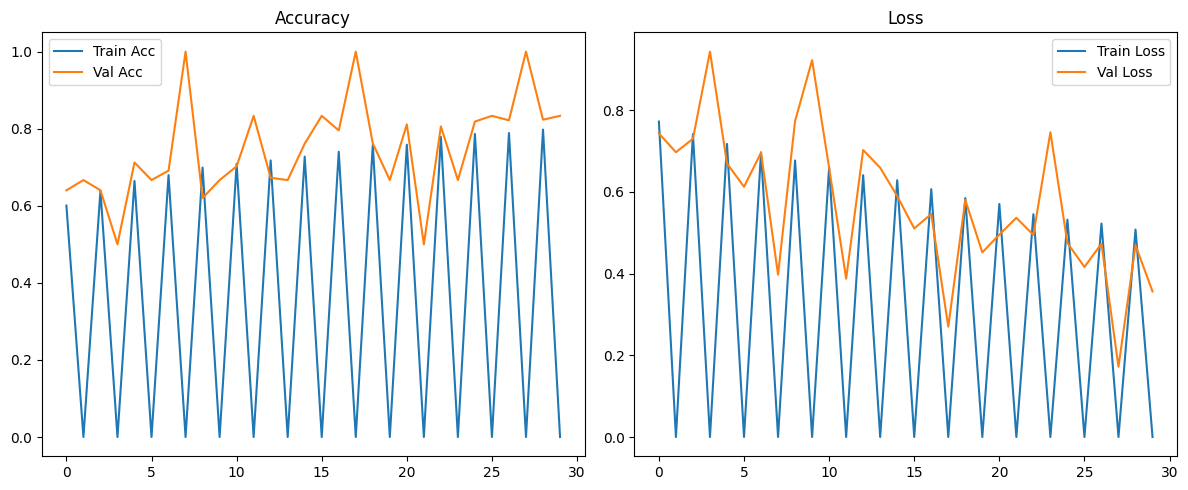

In [10]:
# Plotting
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.tight_layout()
plt.show()

In [11]:
# Evaluate on test data
loss, acc = model.evaluate(test_generator)
print(f"Test accuracy: {acc:.4f}")


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 262ms/step - accuracy: 0.8887 - loss: 0.3825
Test accuracy: 0.8650


In [12]:
#folder_path = '/kaggle/input/dog-and-cat-classification-dataset/PetImages'
#extensions = []
#for fldr in os.listdir(folder_path):
#    sub_folder_path = os.path.join(folder_path, fldr)
#    for filee in os.listdir(sub_folder_path):
#        file_path = os.path.join(sub_folder_path, filee)
#        print('** Path: {}  **'.format(file_path), end="\r", flush=True)
#        im = Image.open(file_path)
#        rgb_im = im.convert('RGB')
#        if filee.split('.')[1] not in extensions:
#            extensions.append(filee.split('.')[1])

In [13]:
#folder_path = '/kaggle/input/cat-dog'
#extensions = []
#for fldr in os.listdir(folder_path):
#    sub_folder_path = os.path.join(folder_path, fldr)
#    for filee in os.listdir(sub_folder_path):
#        file_path = os.path.join(sub_folder_path, filee)
#       print('** Path: {}  **'.format(file_path), end="\r", flush=True)
#        im = Image.open(file_path)
#        rgb_im = im.convert('RGB')
#        if filee.split('.')[1] not in extensions:
#            extensions.append(filee.split('.')[1])

In [14]:
model.save('VGGLike_model.h5')